In [ ]:
# Adjuntar el archivo resources con los scripts
# model.py
# trainer.py
# utils.py
# visualization.py

In [2]:
#pip install datasets

In [3]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [4]:
import torch
from torchvision import transforms
from datasets import load_dataset
from datasets import Dataset as HFDataset
from torch.utils.data import DataLoader

from resources.utils import CovidDataset, plot_class_distribution
from resources.model import (
    create_xception_model,
    create_resnet50_model, # IMPLEMENTAR A CRITERIO
    create_efficientnet_v2_s_model, # IMPLEMENTAR A CRITERIO
    train_model
)
from resources.visualization import (
    plot_confusion_matrix,
    visualize_predictions,
    plot_training_history
)

In [5]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.15),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Load dataset
streaming_dataset = load_dataset("Flooki10/autotrain-data-pr_final_covid-19", streaming=True)
train_dataset_raw = HFDataset.from_list(list(streaming_dataset['train']))
val_dataset_raw = HFDataset.from_list(list(streaming_dataset['test']))

# Create dataset instances
train_dataset = CovidDataset(train_dataset_raw, transform=train_transform)
val_dataset = CovidDataset(val_dataset_raw, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/401 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/101 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/198 [00:00<?, ?it/s]

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create and move model to device
model = create_xception_model(num_classes=3)
model = model.to(device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


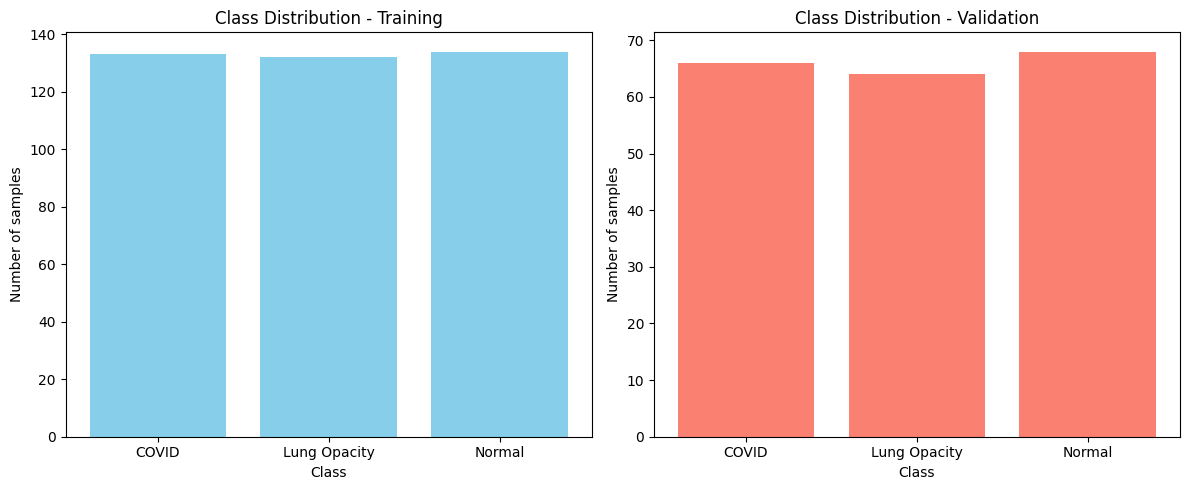

In [8]:
# Define classes
classes = ['COVID', 'Lung Opacity', 'Normal']

# Plot class distribution
plot_class_distribution(train_dataset_raw, val_dataset_raw, classes)

In [9]:
# Training setup
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=2, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [10]:
NUM_EPOCHS = 30
PATH_TO_SAVE_MODELS = "/content/models/xception_models_final" #Cambiar el nombre a tu criterio
PREFIX_NAME_MODELS = "xception_best_model" # nombre prefijo de mis modelos


# Train the model
trained_model, history = train_model(
    model= model,
    train_loader= train_loader,
    val_loader= val_loader,
    criterion= criterion,
    optimizer= optimizer,
    scheduler= scheduler,
    device= device,
    num_epochs= NUM_EPOCHS,
    save_dir= PATH_TO_SAVE_MODELS,
    model_prefix= PREFIX_NAME_MODELS
)

Epoch | Train Loss | Train Acc | Val Loss | Val Acc
------------------------------------------------------
    1 |     0.8179 |    0.6316 |   1.3451 |  0.4545
Model saved: /content/models/xception_models_final/xception_best_model_epoch_1_4to_intent.pth
    2 |     0.4590 |    0.8246 |   1.0340 |  0.6162
Model saved: /content/models/xception_models_final/xception_best_model_epoch_2_4to_intent.pth
    3 |     0.3150 |    0.8797 |   1.4178 |  0.5758
    4 |     0.2809 |    0.9048 |   1.2927 |  0.6162
    5 |     0.2837 |    0.9048 |   0.8675 |  0.7576
Model saved: /content/models/xception_models_final/xception_best_model_epoch_5_4to_intent.pth
    6 |     0.2457 |    0.9073 |   0.3716 |  0.8485
Model saved: /content/models/xception_models_final/xception_best_model_epoch_6_4to_intent.pth
    7 |     0.1869 |    0.9424 |   0.6199 |  0.8283
    8 |     0.1719 |    0.9398 |   0.4257 |  0.8788
Model saved: /content/models/xception_models_final/xception_best_model_epoch_8_4to_intent.pth
    9 |

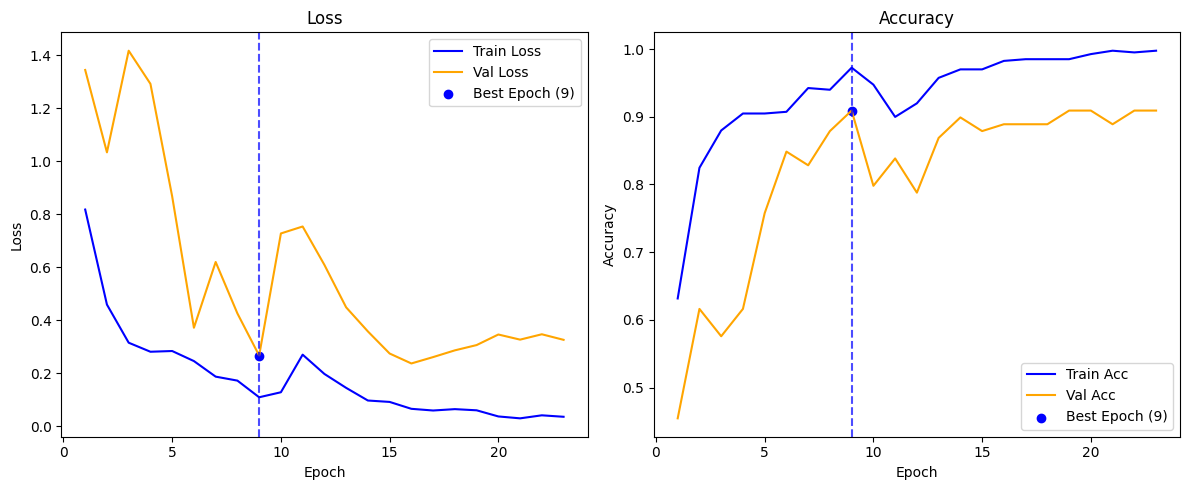

In [11]:
# Plot training history NEEEWWWWW
plot_training_history(
    train_losses=history['train_loss'],
    val_losses=history['val_loss'],
    train_accs=history['train_acc'],
    val_accs=history['val_acc']
)

Classification Report:
              precision    recall  f1-score   support

       COVID       1.00      0.91      0.95        66
Lung Opacity       0.86      0.94      0.90        64
      Normal       0.88      0.88      0.88        68

    accuracy                           0.91       198
   macro avg       0.91      0.91      0.91       198
weighted avg       0.91      0.91      0.91       198



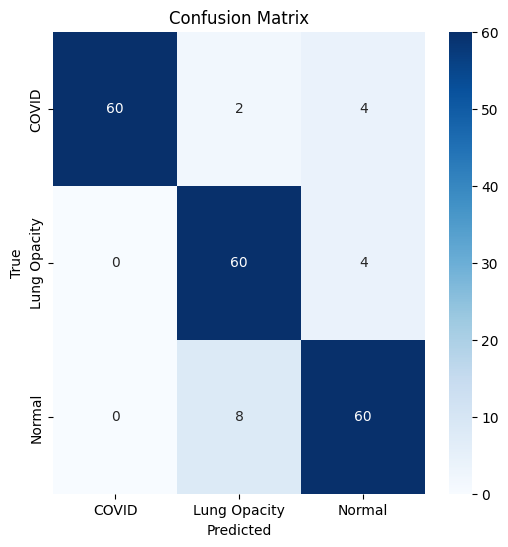

In [12]:
# Evaluate the model
plot_confusion_matrix(trained_model, val_loader, device, classes)

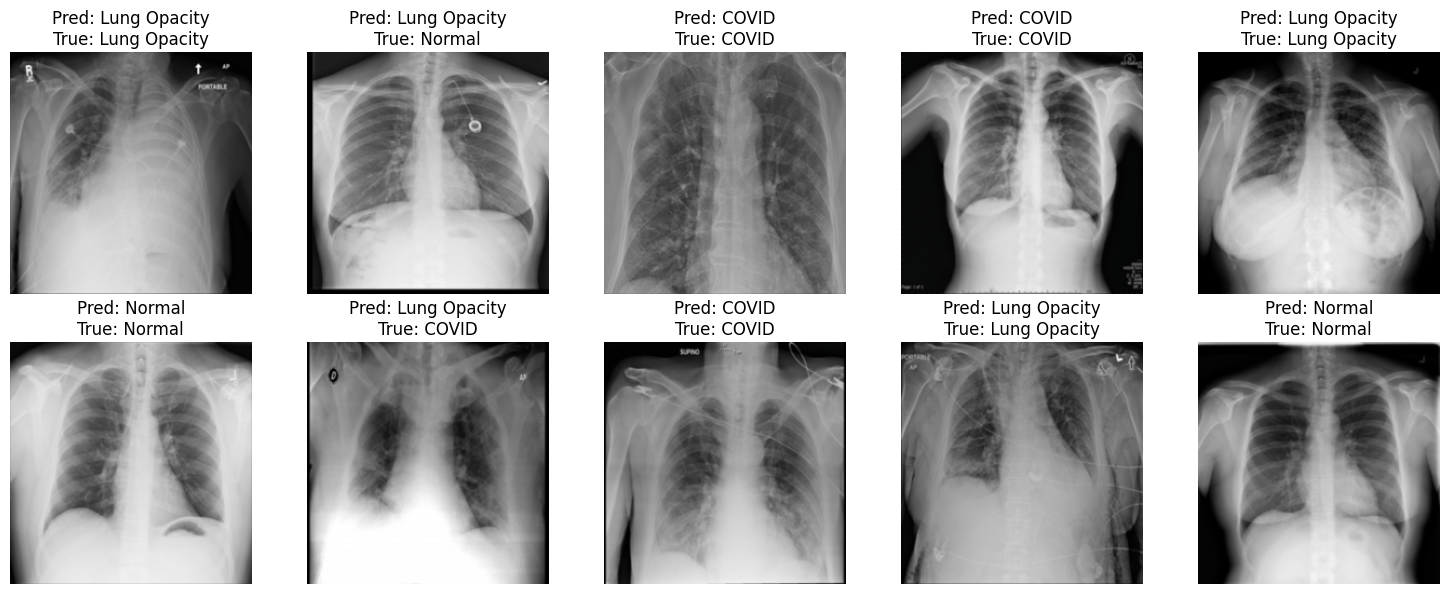

In [13]:
visualize_predictions(trained_model, val_dataset, device, classes)